# Predicción de bajas en una compañia de seguros

#### Objetivo
El objetivo del trabajo es predecir qué clientes anulan la suscripción a un seguro de vida y analizar los factores que influyen en dicho comportamiento. 

#### Contexto
Contamos con datos anónimos de la compañia en cuestión. Debido al contexto altamente inflacionario del mercado argentino, la compañia se ve obligada a aumentar las cuotas del seguro a lo largo de los años. Uno de los problemas con los que se encuentra es que no puede aumentar la cuota para un producto ya existente. Por este motivo realiza campañas de renovación donde el cliente se da da baja del producto actual, y se genera una nueva alta con otro producto actualizado. En cuanto al canal de venta, los seguros se ofrecen principalmente a traves de un banco, y la compañia cuenta con equipos dedicados a la renovación. 

#### Descripción técnica
El trabajo consiste en 2 partes
1.  Generación del dataset: en base a los datos provistos, generación de nuevas variables (no incluido en este repo)
2. Entrenamiento de Modelos predictivos

En la primera parte ajustamos los datos para unificar a los clientes que renovaron, y considerar como anulación únicamente a los clientes que ya no cuentan con ningún servicio. Los datos originales abarcan 20 años. Nos quedamos con la cartera activa al 01/01/2020 y analizamos las bajas hasta 01/07/2021. En cuanto a nuevas variables generadas tenemos: anulacion_target, baja_tipo, edad (alta y actual), permanencia (desde primer alta y desde última renovación), cantidad de productos, actividad_rank_20, conducto_rank_10, zona geográfica.

Dentro de los modelos predictivos usamos: Naive-Bayes como baseline, Logistic Regression, Decision Tree Classifier, Random Forest Classifier, XGBoost Classifier. \
Las principales métricas que vamos a usar son:
- Accuracy: #predicciones correctas / #predicciones totales
- Precision: #verdaderos positivos / #predicciones positivas
- Recall (o sensitividad): #verdaderos positivos / #observaciones positivas (o True Positive Rate)
- AUC: Medida general de la capacidad predictiva del modelo, ponderando la tasa de verdaderos positivos con la de falsos positivos

Los pasos de selección y transformación de features como tambión el entrenamiento del modelo se incluyen en un Pipeline. De esta forma podemos probar distintas estrategias con gridsearch y correr exactamente los mismos pasos cuando necesitemos predecir datos nuevos. 



#### Metodología
1. Separar el dataset en un set de entrenamiento y otro test.\
Vamos a dejar parte de los datos únicamente para evaluar cómo performa nuestro modelo con observaciones nuevas. De lo contrario existe un riesgo grande que el modelo sobreajuste los datos de entrenamiento, y no consiga predecir datos nuevos. El pipeline seráa entrenado únicamente con el set de train. 
2. Selección inicial de features y transformación\
En base a nuestro análisis inicial de features, seleccionamos las que están completas y consideramos que pueden tener buena capacidad predictiva.
3. Selección del modelo\
Comenzamos usando un modelo baseline (Naive Bayes) que podemos usar para comparar con modelos más complejos. Por la naturaleza de nuestros datos, luego elegimos modelos que usan Árboles de Decisión de base. 
4. Configuración del modelo: selección de hiperparámetros\
Para cada modelo probamos distintas combinaciones de ajustes. 
5. Entrenamiento del modelo, evaluación y ajustes\
Una vez que el modelo es entrenado, usamos validación cruzada para evaluar su performance, y también analizamos el peso que cada feature aporta al modelo. Con esta información podemos iterar sobre los ajustes, y también sobre las features que usamos de input. Eliminando features que brindan poca información podemos reducir la complejidad del modelo, manteniendo performance.
6. Selección de modelo y predicciones finales\

# Índice
- [Dataset y distribuciones iniciales](#data)
- [Train, Validation & Test Sets](#train_test)
- [Preprocesamiento](#preprocesamiento)
- [Modelos](#modelos)
    - [Naive Bayes](#nb)
    - [Árboles de decisión](#dt)
    - [Random Forest](#rf)
    - [XGBoost](#xgb)
    - [Logistic Regression](#logistic)
    - [Oversampling](#oversampling)
- [Selección Modelo](#seleccion)
- [Evaluación con test](#test)
- [Conclusiones](#conclusiones)

<a id='data'></a>
## Dataset y distribuciones iniciales

Importación de librerias

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
from collections import OrderedDict

from sklearn.pipeline import make_pipeline,FeatureUnion, Pipeline,make_union
from sklearn.feature_selection import VarianceThreshold,SelectKBest,chi2
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.model_selection import cross_val_score,cross_validate,GridSearchCV, RandomizedSearchCV

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import make_column_transformer,make_column_selector, ColumnTransformer

from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler

from sklearn.metrics import accuracy_score,precision_score,recall_score, roc_auc_score,confusion_matrix, classification_report,roc_curve,plot_precision_recall_curve
from scikitplot.metrics import plot_roc

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.inspection import permutation_importance

from sklearn import tree
from IPython.display import Image
import pydotplus

from lime.lime_tabular import LimeTabularExplainer

import pickle


In [40]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings(action='ignore', category=UserWarning)


In [41]:
#theme para los graficos
sns.set_theme(style='darkgrid')

Importamos el dataset modificado proveniente de la notebook de exploración. 

In [42]:
data=pd.read_csv("data_clean.csv", low_memory=False,decimal='.',thousands=',',
                dtype={'Plan/Producto':'object'}).iloc[:,2:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437659 entries, 0 to 437658
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Codigo_Asegurado            437659 non-null  int64  
 1   Codigo_Contratante          7468 non-null    float64
 2   Localidad_Asegurado         437656 non-null  object 
 3   Premio_Inicial_             437659 non-null  float64
 4   Premio_actual_              437659 non-null  float64
 5   Fecha_de_emision            437659 non-null  object 
 6   Fecha_de_Nacimiento         437659 non-null  object 
 7   Vigencia_desde              437659 non-null  object 
 8   Vigencia_hasta              437659 non-null  object 
 9   Frecuencia_de_facturacion   437659 non-null  object 
 10  Actividad                   437659 non-null  object 
 11  Plan/Producto               437659 non-null  object 
 12  C_igo_de_productor          437659 non-null  int64  
 13  Capital_Asegur

Como primer paso analizamos en qué estado se encuentran los clientes. Alrededor de un 10% son bajas, mientras que el 85% sigue activo y el 5% finalizó el contrato. Como nuestro interes es predecir las bajas, vamos a considerar como "anulacion" la categoria "baja_cliente", y las 2 restantes como no anulación. 

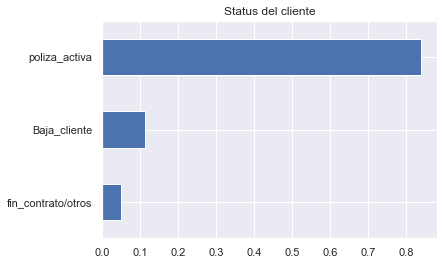

In [43]:
data.Baja_Tipo.value_counts(normalize=True).plot.barh()
plt.gca().invert_yaxis()
plt.title('Status del cliente');

Analizamos cuantos años llevan los clientes con el seguro. La permanencia total refiere a cuantos años hace que contrató el primer producto con la compañia, y permanencia_última desde que hizo la última renovación. 
En el gráfico de la derecha vemos que la mayor cantidad de clientes renovó en los últimos 5 años, y también que quienes anularon se encuentran más concentrados en los primeros 2 años (0 o 1 año de permanencia). 
Analizando la permanencia total en el gráfico de la izquierda vemos que si bien tiene un sesgo hacia la izquierda, los clientes se encuentran más distribuidos a lo largo de los años. También se mantiene que la mayor cantidad de clientes que anula lo hace en los primeros 2 años.

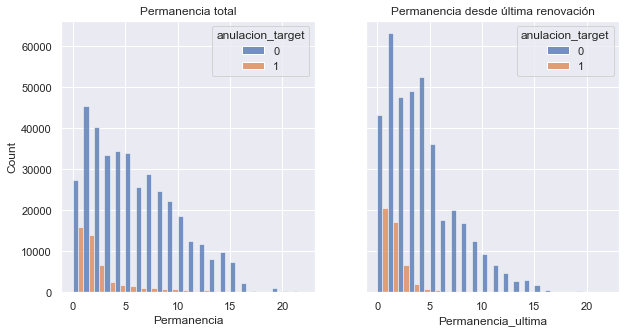

In [44]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.histplot(data=data,x='Permanencia',binwidth=1,hue='anulacion_target',ax=ax[0],multiple='dodge')
sns.histplot(data=data,x='Permanencia_ultima',binwidth=1,hue='anulacion_target',ax=ax[1],multiple='dodge')
ax[0].set_title('Permanencia total')
ax[1].set_title('Permanencia desde última renovación');


Si vemos la edad de los clientes diferenciando por anulación, notamos que hay una diferencia en la forma de la distribución. En el caso de la edad actual las bajas se concentran hacia valores menores (clientes más jóvenes) y los activos un poco mayor. 

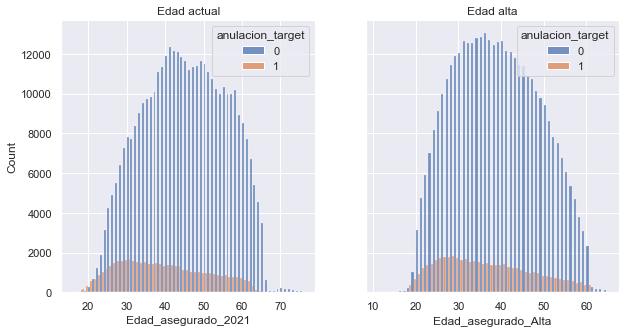

In [45]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.histplot(data=data,x='Edad_asegurado_2021',binwidth=1,hue='anulacion_target',ax=ax[0],multiple='dodge')
sns.histplot(data=data,x='Edad_asegurado_Alta',binwidth=1,hue='anulacion_target',ax=ax[1],multiple='dodge')
ax[0].set_title('Edad actual')
ax[1].set_title('Edad alta');


En cuanto a los motivos de baja, más del 80% lo hace por falta de pago. 

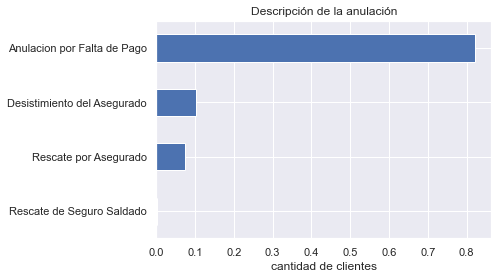

In [46]:
data.loc[data['anulacion_target']==1,'Descripcion_Anulacion'].value_counts(normalize=True).plot.barh();
plt.title('Descripción de la anulación')
plt.xlabel('cantidad de clientes')
plt.gca().invert_yaxis();

La mayor parte de los clientes registra herederos, y dentro de los que no registran herederos, hay muy pocas bajas. Este es un dato que puede estar incompleto por parte del cliente, ya que el default es sin herederos. 

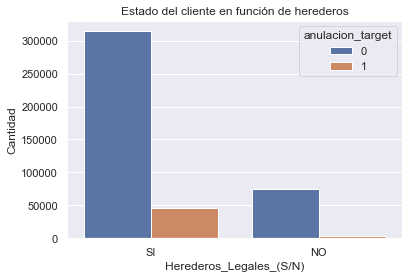

In [47]:
table_herederos=data[['Herederos_Legales_(S/N)','anulacion_target']].value_counts().reset_index().rename(columns={0:'Cantidad'})

sns.barplot(data=table_herederos, x='Herederos_Legales_(S/N)',y='Cantidad',hue='anulacion_target')
plt.title('Estado del cliente en función de herederos');

Si analizamos la variación  del valor de la prima de los seguros, notamos que su valor aumenta con los años. En el caso de la prima para un año particular, vemos que casi todos los clientes tienen el mismo valor. Por lo cual validamos que las diferencias de precio son principalmente por inflación, y para un mismo momento de alta los precios son casi iguales. 

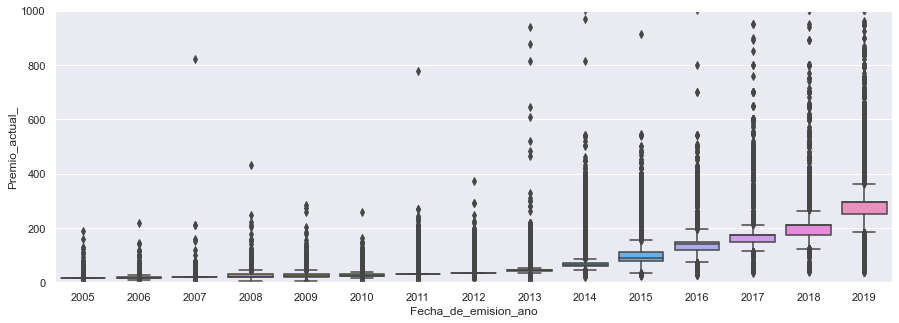

In [48]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data[data['Fecha_de_emision_ano']>2004], x='Fecha_de_emision_ano',y='Premio_actual_')
plt.ylim(0,1000);


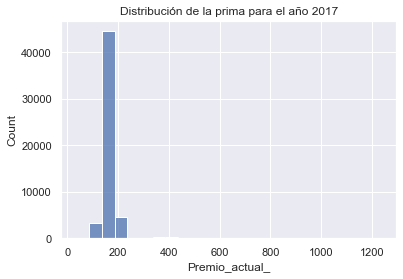

In [49]:
sns.histplot(data=data[data['Fecha_de_emision_ano']==2017], x='Premio_actual_',binwidth=50);
#plt.xlim(0,1000)
plt.title('Distribución de la prima para el año 2017');

En cuanto al medio de pago, el pago directo tiene el mayor % de anulaciones. 

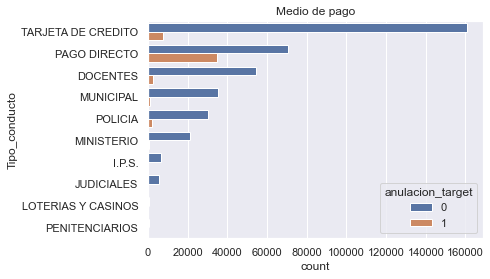

In [50]:
ax=sns.countplot(y=data["Tipo_conducto"], hue=data["anulacion_target"], 
                 order=data["Tipo_conducto"].value_counts().iloc[:10].index, orient='h')
plt.title('Medio de pago');

Si analizamos la actividad declarada, lo primero que notamos es que una mayoría sustancial registra "empleado". Este valor es genérico, y puede estr relacionado que al no ser una actividad de riesgo las primas son menores. La compañia actualmente no hace un control exhaustivo de la veracidad de la actividad de sus clientes. 

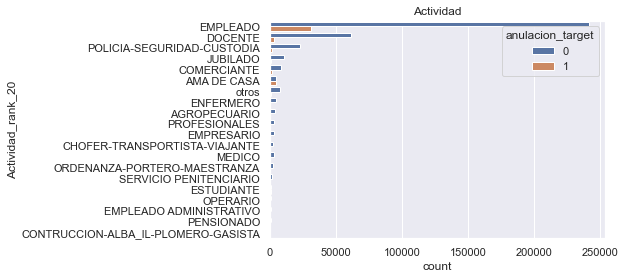

In [51]:
ax=sns.countplot(y=data["Actividad_rank_20"], hue=data["anulacion_target"], 
                 order=data["Actividad_rank_20"].value_counts().iloc[:20].index, orient='h')
plt.title('Actividad');

Por último identificamos que los clientes están principalmente en provincia de Bs As (interior y GBA) y algo en el interior del pais. También vemos que los clientes del interior del pais tienen un porcentaje mayor de anulaciones. 

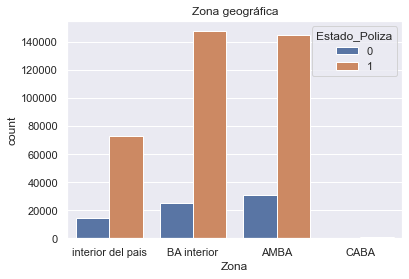

In [52]:
sns.countplot(x=data.Zona, hue=data["Estado_Poliza"])
plt.title('Zona geográfica');

<a id='train_test'></a>
## Train, Validation & Test Sets

Separamos en features y target. Dejamos todas las variables como features ya que van a ser descartadas en el pipeline posteriormente.

In [53]:
X=data.drop('anulacion_target',axis=1)
y=data['anulacion_target']

Partimos el data set en train y test, y a su vez train lo separamos en train y validation. De esta forma podemos mantener un train de test que no se use para elegir el mejor modelo.

In [54]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,random_state=67,stratify=y,test_size=0.2,shuffle=True)
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,random_state=67,stratify=ytrain,test_size=0.2,shuffle=True)

In [55]:
print('Train: ',Xtrain.shape,'Validation: ',Xval.shape,'Test :',Xtest.shape)

Train:  (280101, 42) Validation:  (70026, 42) Test : (87532, 42)


Al analizar los valores de la variable target vemos que contamos con un dataset desbalanceado, con un 11% de bajas.

In [56]:
ytrain.value_counts(normalize=True)

0    0.888176
1    0.111824
Name: anulacion_target, dtype: float64

In [57]:
folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=6)

# Pipeline

Vamos a incluir dentro de un pipeline los pasos de preprocesamiento y el modelo seleccionado.

<a id='preprocesamiento'></a>
## Preprocesamiento

#### Paso 1: Selección y transformación de features

Generamos una clase que nos permita seleccionar las features dinámicamente con el atributo selected features

In [58]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,selected_features):
        self.selected_features=selected_features

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

In [59]:
#Generamos una clase que permita redondear los floats (para reducir los años y las edades)
#class Round(BaseEstimator, TransformerMixin):
 #   def __init__(self):
  #      pass
  #  
  #  def fit(self,X,y=None):
  #      return self
    
  #  def transform(self, X, y=None):
  #      return round(X,0)

Con column transformer podemos aplicar distintas transformaciones a distintas columnas en paralelo. Pasamos las features categóricas a dummies con OneHotEncoder.

In [60]:
#Transformador con OneHotEncoder
column_trans_cat=ColumnTransformer([('onehot',OneHotEncoder(sparse=False,handle_unknown = "error",drop='first'), 
                                 make_column_selector(dtype_include='object')),
                                   ('floats','passthrough',make_column_selector(dtype_include='float')),
                                   ('ints','passthrough',make_column_selector(dtype_include='int'))],
                                     remainder='drop')

#No tenemos floats que vayamos a redondear, ya vienen redondeados 
#Transformador con OneHotEncoder y redondeo de floats
#column_trans_cat_float=ColumnTransformer([('onehot',OneHotEncoder(sparse=False,handle_unknown = "error",drop='first'), 
 #                                make_column_selector(dtype_include='object')),
  #                                 ('floats',make_pipeline(Round()), 
   #                              make_column_selector(dtype_include='float')),
    #                               ('ints','passthrough',make_column_selector(dtype_include='int'))],
     #                                remainder='drop')

Analizamos la correlación entre las features númericas que identificamos que tienen una buena calidad del dato, y podrían ser relevantes para el modelo.

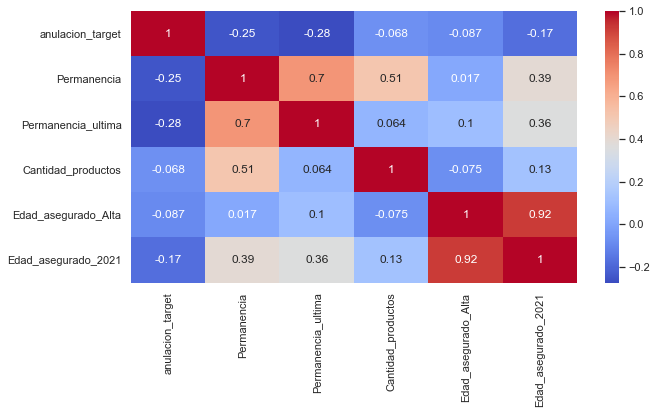

In [61]:
plt.figure(figsize=(10,5))
sns.heatmap(data[['anulacion_target','Permanencia','Permanencia_ultima','Cantidad_productos','Edad_asegurado_Alta','Edad_asegurado_2021',
    'Productor','Herederos_Legales_(S/N)','Conducto_rank_10']].corr(),cmap='coolwarm',annot=True);

Generamos una selección con todas las variables, y una que descarta las que tienen alta correlación (tomamos como threshold >0.75 por lo cual excluimos Edad_asegurado_alta que además tiene baja relación con el target).

In [62]:
#Features completas
selected_features_1=FeatureSelection([
    'Permanencia_ultima','Permanencia','Cantidad_productos','Edad_asegurado_Alta','Edad_asegurado_2021',
    'Productor','Herederos_Legales_(S/N)','Actividad_rank_20','Conducto_rank_10','Zona'])

#Features sin correlacionadas (>0.75)
selected_features_2=FeatureSelection([
    'Permanencia','Edad_asegurado_2021',
    'Productor','Herederos_Legales_(S/N)','Actividad_rank_20','Conducto_rank_10','Zona'])


Generamos los siguientes pipelines

In [63]:
#Preprocesamiento 1: Todas las features sin redondear
pipe_selection_1=make_pipeline(selected_features_1,column_trans_cat)
#Preprocesamiento 2: Todas las features, redondeando
#pipe_selection_2=make_pipeline(selected_features_1,column_trans_cat_float)

#Preprocesamiento 3: Features sin correlacionadas
pipe_selection_3=make_pipeline(selected_features_2,column_trans_cat)


Al incluir la instancia de selección de features en el pipeline tenemos 2 principales beneficios:
1. Podemos incluir distintos sets de features o transformaciones en un grid search
2. En el caso que contemos con nueva informacióm que necesitemos predecir, al correr el pipeline automáticamente se seleccionan los features con los que fue entrenado el modelo. Reducimos posibilidad de errores y líneas de código.

#### Check: Dataset transformado

Revisamos cómo quedaría el dataset transformado con nuestro column transformer.

In [64]:
pipe_selection_1.fit(Xtrain)

Pipeline(steps=[('featureselection',
                 FeatureSelection(selected_features=['Permanencia_ultima',
                                                     'Permanencia',
                                                     'Cantidad_productos',
                                                     'Edad_asegurado_Alta',
                                                     'Edad_asegurado_2021',
                                                     'Productor',
                                                     'Herederos_Legales_(S/N)',
                                                     'Actividad_rank_20',
                                                     'Conducto_rank_10',
                                                     'Zona'])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                            

Al aplicar OneHotEncoder, se pierden los nombres de las features. Para recuperarlos armamos una función.

In [65]:
#feature names - extraer feature names corrigiendo los de one hot encoder
def ExtractFeatureNames(column_transformer):
    onehot_names=column_transformer.transformers_[0][2]   
    onehot_features=column_transformer.transformers_[0][1].get_feature_names(onehot_names)
    float_features=column_transformer.transformers_[1][2]
    int_features=column_transformer.transformers_[2][2]
    feature_names=np.concatenate((onehot_features,float_features,int_features))
    return feature_names


In [66]:
Xtrain_transformed=pd.DataFrame(columns=ExtractFeatureNames(pipe_selection_1.named_steps['columntransformer']),data=pipe_selection_1.transform(Xtrain))
Xtrain_transformed.head()

,Productor_Otros,Herederos_Legales_(S/N)_SI,Actividad_rank_20_AMA DE CASA,Actividad_rank_20_CHOFER-TRANSPORTISTA-VIAJANTE,Actividad_rank_20_COMERCIANTE,Actividad_rank_20_CONTRUCCION-ALBA_IL-PLOMERO-GASISTA,Actividad_rank_20_DOCENTE,Actividad_rank_20_EMPLEADO,Actividad_rank_20_EMPLEADO ADMINISTRATIVO,Actividad_rank_20_EMPRESARIO,...,Conducto_rank_10_TARJETA DE CREDITO,Conducto_rank_10_otros,Zona_BA interior,Zona_CABA,Zona_interior del pais,Permanencia_ultima,Permanencia,Edad_asegurado_Alta,Cantidad_productos,Edad_asegurado_2021
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,10.0,44.0,1.0,54.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,56.0,2.0,60.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,5.0,13.0,34.0,4.0,48.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,7.0,7.0,37.0,2.0,45.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,1.0,36.0


In [67]:
Xtrain_transformed.shape

(280101, 40)

Volver a llevar x e y a un mismo dataframe

In [68]:
df_transformed=Xtrain_transformed.join(ytrain.reset_index(drop=True))
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280101 entries, 0 to 280100
Data columns (total 41 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Productor_Otros                                        280101 non-null  float64
 1   Herederos_Legales_(S/N)_SI                             280101 non-null  float64
 2   Actividad_rank_20_AMA DE CASA                          280101 non-null  float64
 3   Actividad_rank_20_CHOFER-TRANSPORTISTA-VIAJANTE        280101 non-null  float64
 4   Actividad_rank_20_COMERCIANTE                          280101 non-null  float64
 5   Actividad_rank_20_CONTRUCCION-ALBA_IL-PLOMERO-GASISTA  280101 non-null  float64
 6   Actividad_rank_20_DOCENTE                              280101 non-null  float64
 7   Actividad_rank_20_EMPLEADO                             280101 non-null  float64
 8   Actividad_rank_20_EMPLEADO ADMINIS

#### Análisis de correlación con la variable target

Analizamos la correlación de cada una de las variables, incluidas las dummy con la variable target.

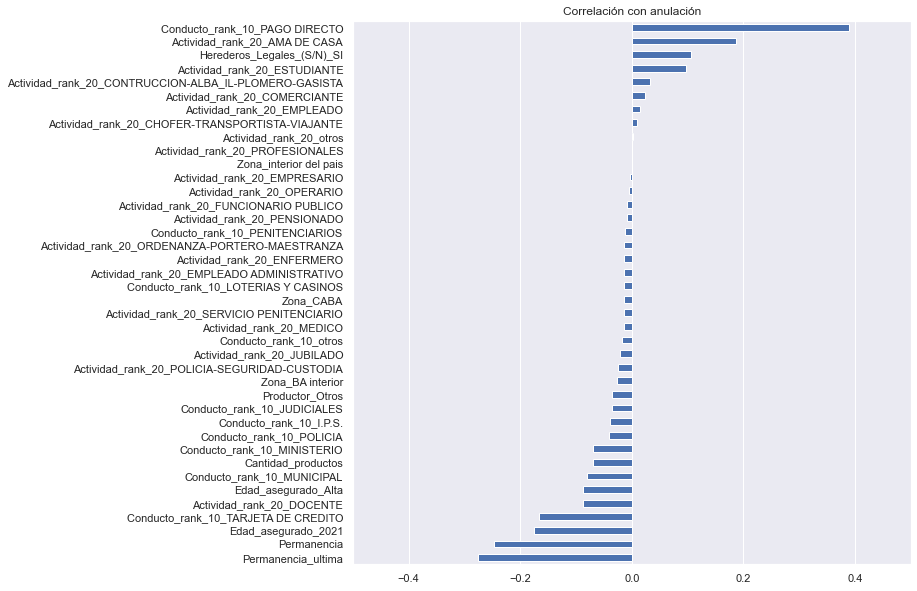

In [69]:
plt.figure(figsize=(10,10))
df_transformed.corr()['anulacion_target'].drop(index='anulacion_target').sort_values().plot.barh()
plt.grid(axis='y')
plt.xlim(-0.5,0.5)
plt.title('Correlación con anulación');

#### Paso 2: Feature Selection

Dejamos un paso de SelectKBest con 'all' como k, que luego en la etapa de grid search podemos cambiar por otros valores.

In [70]:
k_best=SelectKBest(chi2, k ='all')

#### Paso 3: Scaler

Generamos escaladores para las variables numéricas.

In [71]:
standard_scaler=StandardScaler()

In [72]:
minmax_scaler=MinMaxScaler()

<a id='modelos'></a>
## Modelos ML

Definimos funciones que serán utilizadas para ver resultados

In [73]:
#Correr el pipeline con el set de train y validación y comparar resultados
def train_val_results(pipe,Xtrain,ytrain,Xval,yval):
    ypred_train=pipe.predict(Xtrain)
    ypred_val=pipe.predict(Xval)
    print('train acc: ',accuracy_score(ytrain,ypred_train),'validation acc: ',accuracy_score(yval,ypred_val))
    print('train auc: ',roc_auc_score(ytrain,pipe.predict_proba(Xtrain)[:,1]),'validation auc: ',roc_auc_score(yval,pipe.predict_proba(Xval)[:,1]))
    print('train prec: ',precision_score(ytrain,ypred_train),'validation prec: ',precision_score(yval,ypred_val))
    print('train recall: ',recall_score(ytrain,ypred_train),'validation recall: ',recall_score(yval,ypred_val))


In [74]:
#correr cross validation y registrar resultados
def calculate_cv_results(pipe,X,y,model_name):
    cv_results=cross_validate(pipe,X,y,scoring=['accuracy','roc_auc','precision','recall'],cv=folds)
    results={
        'Model':model_name,
        'Accuracy CV':cv_results['test_accuracy'].mean(),
        'Accuracy STD': cv_results['test_accuracy'].std(),
        'Precision CV': cv_results['test_precision'].mean(),
        'Recall CV': cv_results['test_recall'].mean(),
        'AUC CV':cv_results['test_roc_auc'].mean(),        
    }
    
    print('mean accuracy: ',results['Accuracy CV'],'std_accuracy: ',results['Accuracy STD'])
    print('mean roc_auc: ',results['AUC CV'],'std roc_auc',cv_results['test_roc_auc'].std())
    print('mean precision: ',results['Precision CV'],'std precision',cv_results['test_precision'].std())
    print('mean recall: ',results['Recall CV'],'std recall',cv_results['test_recall'].std())
   
    return results
    
    
    
    

In [75]:
#extrr los resultados de un grid search
def results_grid(search_model,model_name):
    cv_results=pd.DataFrame(search_model.cv_results_)
    best_results=cv_results[cv_results['rank_test_roc_auc']==1]
    results={
        'Model':model_name,
        'Accuracy CV': best_results['mean_test_accuracy'].values[0],
        'Accuracy STD': best_results['std_test_accuracy'].values[0],
        'Precision CV': best_results['mean_test_precision'].values[0],
        'Recall CV': best_results['mean_test_recall'].values[0],
        'AUC CV':best_results['mean_test_roc_auc'].values[0],
        #'Average Precision Score':average_precision_score(yval,model.predict_proba(Xval)[:, 1]),
        #'Accuracy Val': accuracy_score(yval,ypred_val),
        #'Precision Val': precision_score(yval,ypred_val),
        #'AUC Val': roc_auc_score(yval,model.predict_proba(Xval)[:,1]),        
        #'Recall Val': recall_score(yval,ypred_val),
        'Params':search_model.best_params_
        #'ypred_val':ypred_val
    }
                                                                 
    print('Accuracy:',results['Accuracy CV'],', Std: ',results['Accuracy STD'])
    #print('Avg Precision Score: ',results['Average Precision Score'])
    print('Precision CV: ',results['Precision CV'])
    print('Recall CV: ',results['Recall CV']) 
    print('AUC CV: ',results['AUC CV'])    
    print('Params:', results['Params'])

    
    return results



In [76]:
def FeatureImportances(pipe,model_step_name):
    columns_transformer=pipe.named_steps['features'].named_steps['columntransformer']
    #conseguir feature importances
    importances=pipe.named_steps[model_step_name].feature_importances_
    #conseguir mascara para las features que fueron seleccionadas por kbest
    mask_kbest=pipe.named_steps['kbest'].get_support()
    #conseguir nombres de las features del primer paso, y pasarle la mascara de kbest
    feature_names=ExtractFeatureNames(columns_transformer)[mask_kbest]
    feature_importances=pd.Series(index=feature_names,data=importances).sort_values(ascending=False)
    return feature_importances


In [77]:
#Plotear Accuracy, AUC, precision y recall para distintas combinaciones de hiperparametros
def plot_results(results,param_x,param_hue=None):
    fig,ax=plt.subplots(2,2,figsize=(15,8))
    if param_hue:
        results_1=results[[param_x,param_hue,'mean_test_accuracy','mean_test_roc_auc','mean_test_precision','mean_test_recall']]
        sns.lineplot(data=results_1,x=param_x,y='mean_test_accuracy',ax=ax[0,0],marker='o',hue=param_hue,palette='Spectral')
        sns.lineplot(data=results_1,x=param_x,y='mean_test_roc_auc',ax=ax[0,1],marker='o',hue=param_hue,palette='Spectral')
        sns.lineplot(data=results_1,x=param_x,y='mean_test_precision',ax=ax[1,0],marker='o',hue=param_hue,palette='Spectral')
        sns.lineplot(data=results_1,x=param_x,y='mean_test_recall',ax=ax[1,1],marker='o',hue=param_hue,palette='Spectral')

    else:
        results_1=results[[param_x,'mean_test_accuracy','mean_test_roc_auc']]
        sns.lineplot(data=results_1,x=param_x,y='mean_test_accuracy',ax=ax[0,0],marker='o')
        sns.lineplot(data=results_1,x=param_x,y='mean_test_roc_auc',ax=ax[0,1],marker='o')
        sns.lineplot(data=results_1,x=param_x,y='mean_test_precision',ax=ax[1,0],marker='o')
        sns.lineplot(data=results_1,x=param_x,y='mean_test_recall',ax=ax[1,1],marker='o')
         
    
    param_name=param_x.split('__')[1]
    xticks=results[param_x].astype(float)
    ax[0,0].set(title='Accuracy',xlabel=param_name,xticks=xticks)
    ax[0,1].set(title='AUC',xlabel=param_name,xticks=xticks)
    ax[1,0].set(title='Precision',xlabel=param_name,xticks=xticks)
    ax[1,1].set(title='Recall',xlabel=param_name,xticks=xticks)


    ax[0,0].ticklabel_format(style='plain',useOffset=False)
    ax[0,1].ticklabel_format(style='plain',useOffset=False)
    ax[1,0].ticklabel_format(style='plain',useOffset=False)
    ax[1,1].ticklabel_format(style='plain',useOffset=False)
            
    #ax[0,0].grid()
    #ax[0,1].grid()
    #ax[1,0].grid()
    #ax[1,1].grid()
    
    plt.tight_layout();

In [78]:
#graficar un árbol de decisión
def plot_tree(model_tree,feature_names):
    dot_data = tree.export_graphviz(model_tree, out_file=None,feature_names= feature_names, filled = True)
    graph2 = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph2.create_png())

In [79]:

def run_lime(model,X,y,i):
    Xtrain_explainer = np.array(X)
    explainer = LimeTabularExplainer(Xtrain_explainer, 
                                 mode = "classification",
                                 training_labels = y,
                                 feature_names = X.columns, 
                                 categorical_features  = list(range(2,32)),
                                 discretize_continuous=False)
    i = i
    data_row = np.array(X.iloc[i]) # necesito que sea un np array:
    explanation = explainer.explain_instance(data_row, model.predict_proba, num_features=len(data_row))
    explanation.show_in_notebook(show_table=True)

In [80]:
def PermutationImportance(model,Xtrain,ytrain):

    model.fit(Xtrain,ytrain)
    imps = permutation_importance(model, Xtrain, ytrain,n_jobs=4,random_state=5,scoring='roc_auc')
    importances = imps.importances_mean
    std = imps.importances_std
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(Xtrain.shape[1]):
        print("%d. %s (%f)" % (f + 1, Xtrain.columns[indices[f]], importances[indices[f]]))
    
    return importances

<a id='nb'></a>
### Baseline Naive Bayes

El primer modelo utilizado es a modo de baseline. De esta forma tenemos una comparación para el resto de nuestros modelos.

In [81]:
nb_gaussian=GaussianNB()
nb_multinom=MultinomialNB()

In [82]:
pipe_nb=Pipeline([('features',pipe_selection_1),('kbest',k_best),
                  ('model',MultinomialNB())])

Analizamos con permutation importance las features más relevantes.

In [83]:
PermutationImportance(pipe_nb,Xtrain,ytrain);

Feature ranking:
1. Permanencia_ultima (0.117799)
2. Permanencia (0.065192)
3. Conducto_rank_10 (0.042444)
4. Actividad_rank_20 (0.007060)
5. Cantidad_productos (0.000301)
6. Herederos_Legales_(S/N) (0.000109)
7. Actividad (0.000000)
8. Codigo_Conducto (0.000000)
9. Descripcion_Anulacion (0.000000)
10. Fecha_Anulacion (0.000000)
11. Capital_Asegurado_Muerte (0.000000)
12. C_igo_de_productor (0.000000)
13. Plan/Producto (0.000000)
14. Vigencia_desde (0.000000)
15. Frecuencia_de_facturacion (0.000000)
16. Vigencia_hasta (0.000000)
17. Fecha_de_Nacimiento (0.000000)
18. Fecha_de_emision (0.000000)
19. Premio_actual_ (0.000000)
20. Premio_Inicial_ (0.000000)
21. Localidad_Asegurado (0.000000)
22. Codigo_Contratante (0.000000)
23. Descripcion_Conducto (0.000000)
24. Fecha_de_emision_ano (0.000000)
25. Capital_de_Supervivencia (0.000000)
26. Baja_Tipo (0.000000)
27. conducto_debito (0.000000)
28. Tipo_conducto (0.000000)
29. localidad_ranking_50 (0.000000)
30. Edad_asegurado_Baja (0.000000)


Hay features que empeoran la performance del modelo. Generamos un nuevo set de features solo con features con importance > 0.5% y lo actualizamos en el pipeline

In [84]:
selected_features_4=FeatureSelection([
    'Permanencia','Permanencia_ultima',
    'Actividad_rank_20','Conducto_rank_10'])
pipe_selection_4=make_pipeline(selected_features_4,column_trans_cat)
pipe_nb.set_params(features=pipe_selection_4);

Corremos grid search con las nuevas features y distintos valores de kbest y modelos naive bayes. 

In [85]:
params_nb=dict(
    model=[nb_multinom,nb_gaussian],
    kbest__k=[15,'all'],
    
)
nb_search=GridSearchCV(pipe_nb,param_grid=params_nb,
                       scoring=['accuracy','roc_auc','precision','recall'],refit='roc_auc',verbose=1,n_jobs=-1)
nb_search.fit(Xtrain,ytrain)
nb_results=results_grid(nb_search,'Naive Bayes');

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.0s finished


Accuracy: 0.8897719040191877 , Std:  0.001356632653929099
Precision CV:  0.5102210924265036
Recall CV:  0.3671220896158288
AUC CV:  0.8613616577822499
Params: {'kbest__k': 15, 'model': MultinomialNB()}


Guardamos los resultados del modelo en un dataframe que vamos a utilizar para comparar con los siguientes.

In [86]:
nb_results=OrderedDict(nb_results)
columns=nb_results.keys()
scores=pd.DataFrame(columns=columns)
scores=scores.append(nb_results,ignore_index=True)
scores

,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}"


<a id='dt'></a>
### Árbol de decisión

Seguimos con un árbol de decisión. Este es un modelo relativamente simple, con el beneficio que tiene una interpretación clara. Cuantos más niveles tengamos corremos el riesgo de overfitting, y además se complejiza la explicación. Por este motivo vamos a intentar recortar los niveles de los árboles.

Instanciamos un árbol de decisión

In [87]:
dt=DecisionTreeClassifier()

#### Pipeline

Generamos un pipeline que selecciona las features, genera las variables dummy, y corre el modelo de árbol de decisión

In [88]:
pipe_dt=Pipeline([('features',pipe_selection_1),('kbest',k_best),
                  ('decisiontreeclassifier',dt)])

Analizamos los resultados con Cross Validation

In [89]:
calculate_cv_results(pipe_dt,Xtrain,ytrain,'DT');

mean accuracy:  0.8768658465346622 std_accuracy:  0.0003515592590569714
mean roc_auc:  0.7615090467772937 std roc_auc 0.001903199357531314
mean precision:  0.43490753955925454 std precision 0.0014825876915893635
mean recall:  0.33784564045014825 std recall 0.004615443564005805


Analizamos el resultado en el set de train y validation por separado para identificar si tenemos overfitting

In [90]:
pipe_dt.fit(Xtrain,ytrain)
train_val_results(pipe_dt,Xtrain,ytrain,Xval,yval)

train acc:  0.9338488616606153 validation acc:  0.877816810898809
train auc:  0.9702449655375393 validation auc:  0.7682691513180391
train prec:  0.7852651295544754 validation prec:  0.4406668846028114
train recall:  0.5621607815592874 validation recall:  0.3443167305236271


In [91]:
pipe_dt.named_steps['decisiontreeclassifier'].get_depth()

42

Usando todas las variables, el árbol de decisión genera overfitting.

Evaluamos la influencia de cada feature con Permutation Importance.

In [92]:
FeatureImportances(pipe_dt,'decisiontreeclassifier')

Conducto_rank_10_PAGO DIRECTO                            0.264508
Permanencia_ultima                                       0.203125
Edad_asegurado_2021                                      0.135310
Edad_asegurado_Alta                                      0.128969
Permanencia                                              0.066691
Cantidad_productos                                       0.050649
Zona_interior del pais                                   0.024958
Zona_BA interior                                         0.024074
Herederos_Legales_(S/N)_SI                               0.018805
Actividad_rank_20_EMPLEADO                               0.017510
Actividad_rank_20_POLICIA-SEGURIDAD-CUSTODIA             0.005984
Actividad_rank_20_AMA DE CASA                            0.005598
Actividad_rank_20_COMERCIANTE                            0.004800
Productor_Otros                                          0.003703
Conducto_rank_10_TARJETA DE CREDITO                      0.003674
Actividad_

Vemos que hay muchas variables con un peso muy bajo. En especial en el caso de actividad, vemos que todas las dummies tienen muy poco peso, por lo cual podríamos sacarlas del modelo sin tener mayor impacto.

#### Grid search

Vamos a analizar con grid search cual puede ser un valor conveniente de max_depth y min_impurity_decrease para reducir el overfitting.


In [93]:

params=dict(decisiontreeclassifier__max_depth=range(5,21,5),
            #decisiontreeclassifier__max_leaf_nodes=[None,10],
            decisiontreeclassifier__min_impurity_decrease=[0.001,0],
            #Sacamos Actividad porque no tiene impacto y genera muchas dummies
            #features__featureselection__selected_features=[[
            #'Permanencia','Cantidad_productos','Edad_asegurado_Alta','Edad_ultima',
            #'Productor','Herederos_Legales_(S/N)','Conducto_rank_10','Zona']]
           )

search_dt=GridSearchCV(pipe_dt, param_grid=params,
                    scoring=['accuracy','roc_auc','precision','recall'],refit='roc_auc',verbose=1,n_jobs=-1)
search_dt.fit(Xtrain,ytrain)
results_dt_max_depth=results_grid(search_dt,'Best Decision Tree')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


Accuracy: 0.8988614823070155 , Std:  0.0004710817598546041
Precision CV:  0.5852937962552124
Recall CV:  0.32864999352766644
AUC CV:  0.875789082333022
Params: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_impurity_decrease': 0}


Graficamos para las distintas combinaciones de hiperparámetros los resultados. Si bien el mejor resultado de AUC en este caso se da con 10 niveles, no vemos que haya una gran diferencia con 5.

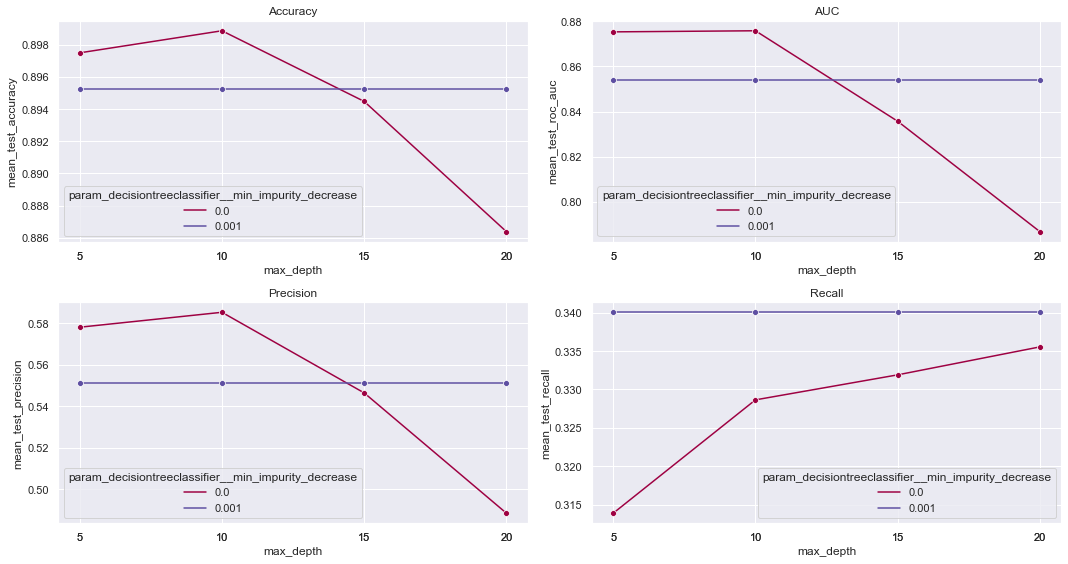

In [94]:
results=pd.DataFrame(search_dt.cv_results_).fillna(0)
plot_results(results,'param_decisiontreeclassifier__max_depth','param_decisiontreeclassifier__min_impurity_decrease')


Al analizar la importancia de las features identificamos la permanencia desde la última renovación y el conducto de pago (en especial el pago directo) como las más importantes. 

In [95]:
PermutationImportance(search_dt,Xtrain,ytrain);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   54.6s finished


Feature ranking:
1. Permanencia_ultima (0.226087)
2. Conducto_rank_10 (0.144966)
3. Edad_asegurado_2021 (0.057503)
4. Actividad_rank_20 (0.026939)
5. Edad_asegurado_Alta (0.025976)
6. Permanencia (0.017811)
7. Cantidad_productos (0.009062)
8. Zona (0.006445)
9. Productor (0.003456)
10. Herederos_Legales_(S/N) (0.002655)
11. Localidad_Asegurado (0.000000)
12. Vigencia_hasta (0.000000)
13. Capital_Asegurado_Muerte (0.000000)
14. C_igo_de_productor (0.000000)
15. Plan/Producto (0.000000)
16. Actividad (0.000000)
17. Frecuencia_de_facturacion (0.000000)
18. Fecha_de_Nacimiento (0.000000)
19. Vigencia_desde (0.000000)
20. Fecha_de_emision (0.000000)
21. Descripcion_Anulacion (0.000000)
22. Premio_actual_ (0.000000)
23. Codigo_Contratante (0.000000)
24. Premio_Inicial_ (0.000000)
25. Fecha_Anulacion (0.000000)
26. Fecha_de_emision_ano (0.000000)
27. Codigo_Conducto (0.000000)
28. Descripcion_Conducto (0.000000)
29. Capital_de_Supervivencia (0.000000)
30. Fecha_de_emision_first_ano (0.000000)

Hay muchas variables con pesos muy bajos que eventualmente podrían eliminarse para simplificar el modelo. 

Analizamos los Feature importances, con resultados en linea con permutation importance. 

In [96]:
FeatureImportances(search_dt.best_estimator_,'decisiontreeclassifier')

Conducto_rank_10_PAGO DIRECTO                            0.497826
Permanencia_ultima                                       0.347841
Edad_asegurado_2021                                      0.029537
Edad_asegurado_Alta                                      0.022670
Actividad_rank_20_EMPLEADO                               0.020483
Zona_BA interior                                         0.017720
Permanencia                                              0.011151
Cantidad_productos                                       0.011058
Actividad_rank_20_AMA DE CASA                            0.007694
Conducto_rank_10_TARJETA DE CREDITO                      0.006914
Actividad_rank_20_POLICIA-SEGURIDAD-CUSTODIA             0.004296
Actividad_rank_20_DOCENTE                                0.002194
Herederos_Legales_(S/N)_SI                               0.002166
Productor_Otros                                          0.002085
Zona_interior del pais                                   0.001760
Conducto_r

Agregamos los resultados a scores y sumamos la cantidad de hojas y la profundidad como medidas de complejidad del modelo.

In [97]:
def add_n_leaves(model,score_df,model_name):
    leaves=model.get_n_leaves()
    score_df.loc[score_df.Model==model_name,'leaves']=leaves
    return score_df

In [98]:
def add_depth(model,score_df,model_name):
    depth=model.get_depth()
    score_df.loc[score_df.Model==model_name,'depth']=depth
    return score_df

In [99]:
scores=scores.append(results_dt_max_depth,ignore_index=True)
dt_model=search_dt.best_estimator_.named_steps['decisiontreeclassifier']
add_n_leaves(dt_model,scores,'Best Decision Tree')
add_depth(dt_model,scores,'Best Decision Tree')
scores

,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params,leaves,depth
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}",NaN,NaN
1,Best Decision Tree,0.898861,0.000471,0.585294,0.328650,0.875789,"{'decisiontreeclassifier__max_depth': 10, 'dec...",735.0,10.0


#### Árbol de decisión simple

Con grid search vimos que no hay cambios significativos entre un árbol de 5 niveles con el de 10. Dado que un modelo con menor profundidad es más simple, generamos una nuevo con dicho hiperparámetro. De esta forma logramos reducir de 735 a 16 hojas, y podemos visualizar el árbol completo.

In [100]:
dt=DecisionTreeClassifier()
pipe_dt=Pipeline([('features',pipe_selection_1),('kbest',k_best),
                  ('decisiontreeclassifier',dt)])

In [101]:
pipe_dt.set_params(decisiontreeclassifier__max_depth=4,
                   decisiontreeclassifier__min_impurity_decrease=0,
                   decisiontreeclassifier__min_samples_leaf=1,
                   kbest__k='all')
dt_simple=deepcopy(pipe_dt.fit(Xtrain,ytrain))
results_dt_simple=calculate_cv_results(dt_simple,Xtrain,ytrain,'Decision Tree Simple')

mean accuracy:  0.8955162622911192 std_accuracy:  0.0005190809470672817
mean roc_auc:  0.8708691728855363 std roc_auc 0.0012148357351613069
mean precision:  0.5580787319650026 std precision 0.01652833346773345
mean recall:  0.3305976715907365 std recall 0.05276956316300162


Representamos gráficamente el árbol de decisión resultante. Los clientes con mayor probabilidad de baja son los que pagan directo, tienen menos de 1 año y menos de 27 años.

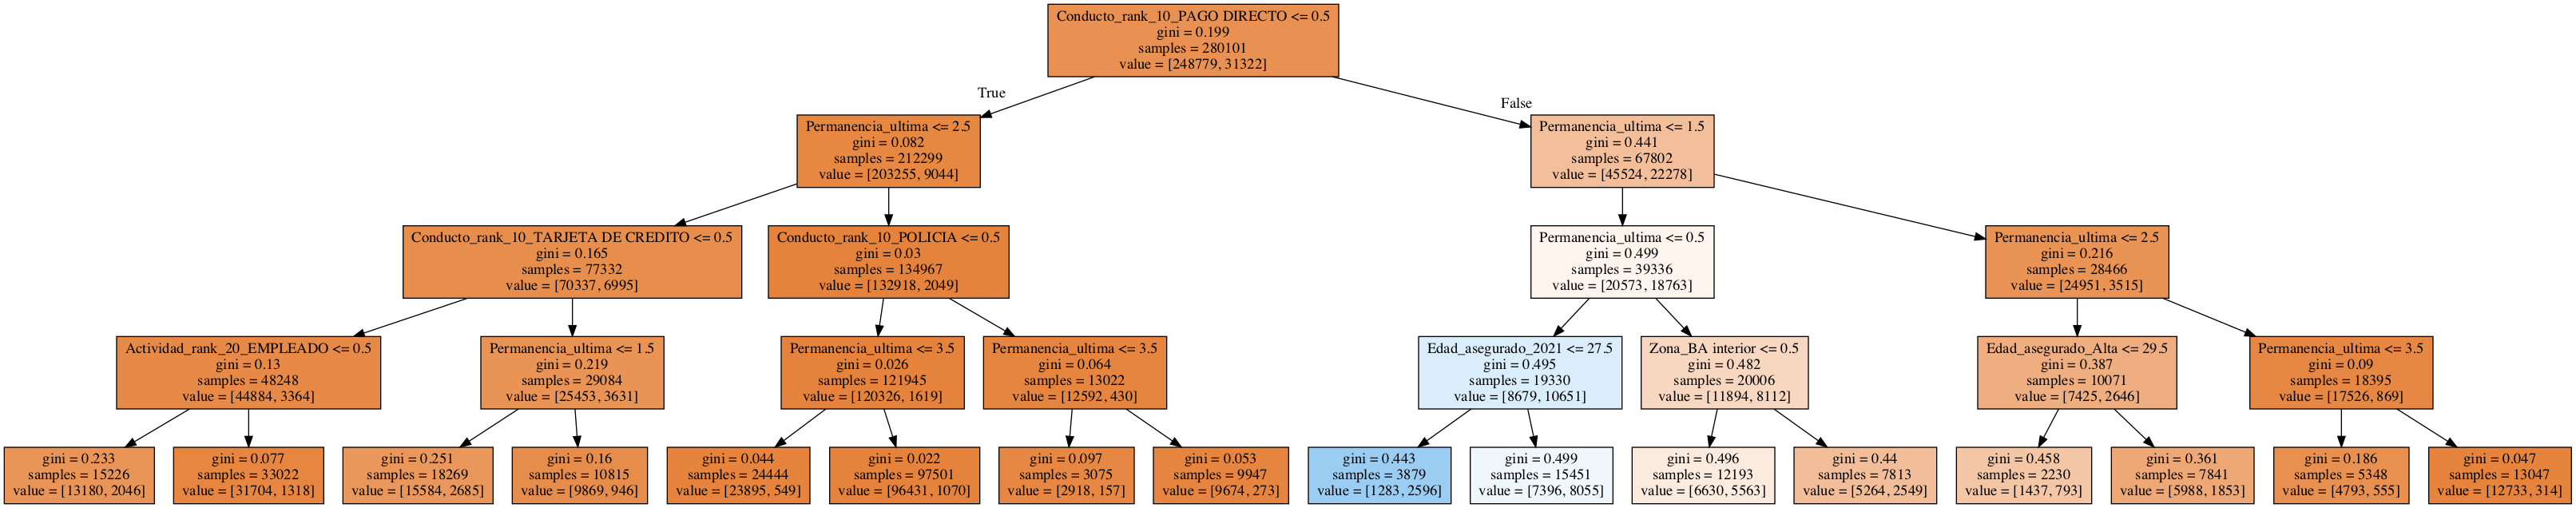

In [102]:
columns_transformer=pipe_dt.named_steps['features'].named_steps['columntransformer']
mask_kbest=pipe_dt.named_steps['kbest'].get_support()
#conseguir nombres de las features del primer paso, y pasarle la mascara de kbest
feature_names=ExtractFeatureNames(columns_transformer)[mask_kbest]
treeplot=plot_tree(pipe_dt.named_steps['decisiontreeclassifier'],feature_names)
treeplot

In [103]:
scores=scores.append(results_dt_simple,ignore_index=True)
dt_model=dt_simple.named_steps['decisiontreeclassifier']
add_n_leaves(dt_model,scores,'Decision Tree Simple')
add_depth(dt_model,scores,'Decision Tree Simple')
scores

,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params,leaves,depth
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}",NaN,NaN
1,Best Decision Tree,0.898861,0.000471,0.585294,0.328650,0.875789,"{'decisiontreeclassifier__max_depth': 10, 'dec...",735.0,10.0
2,Decision Tree Simple,0.895516,0.000519,0.558079,0.330598,0.870869,NaN,16.0,4.0


Recuperamos los feature importances del modelo. Al igual que en el árbol más complejo, el pago directo y los años desde la última renovación son las features con más importancia. 

In [104]:
FeatureImportances(dt_simple,'decisiontreeclassifier')

Conducto_rank_10_PAGO DIRECTO                            0.565387
Permanencia_ultima                                       0.390794
Actividad_rank_20_EMPLEADO                               0.012510
Zona_BA interior                                         0.010825
Edad_asegurado_2021                                      0.009127
Conducto_rank_10_TARJETA DE CREDITO                      0.007417
Edad_asegurado_Alta                                      0.003323
Conducto_rank_10_POLICIA                                 0.000617
Conducto_rank_10_PENITENCIARIOS                          0.000000
Conducto_rank_10_JUDICIALES                              0.000000
Conducto_rank_10_LOTERIAS Y CASINOS                      0.000000
Conducto_rank_10_MINISTERIO                              0.000000
Conducto_rank_10_MUNICIPAL                               0.000000
Conducto_rank_10_otros                                   0.000000
Actividad_rank_20_otros                                  0.000000
Zona_CABA 

In [105]:
print(classification_report(yval,dt_simple.predict(Xval)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     62196
           1       0.55      0.34      0.42      7830

    accuracy                           0.89     70026
   macro avg       0.73      0.65      0.68     70026
weighted avg       0.88      0.89      0.88     70026



<a id='rf'></a>
### Random Forest

Probamos con un modelo de random forest y distintos valores de los parámetros max_depth y max_features para identificar si conseguimos mejoras con un modelo de ensamble. \
Para ajustar por desbalanceo usamos el parámetro class_weight='balanced'. Esta estrategia da más peso a los positivos (anulación=1), lo que resulta en un incremento de recall (pasa de 0.33 a 0.80) pero una pérdida de precision (0.55 a 0.36).

In [106]:
rf=RandomForestClassifier(class_weight='balanced')

In [107]:
pipe_rf=Pipeline([('features',pipe_selection_1),('kbest',k_best),
                  ('randomforest',rf)])

In [108]:
params = dict(randomforest__max_depth=[5, 10, 15],
              randomforest__max_features=[0.3, 0.7],
              randomforest__n_estimators=[50],
              randomforest__max_samples=[0.7],
              #eliminamos Actividad que generaba muchas dummies y no aumenta la performance
              #features__featureselection__selected_features=[[
              #'Permanencia','Cantidad_productos','Edad_ultima',
              #'Productor','Herederos_Legales_(S/N)','Conducto_rank_10','Zona']]
              )

search_rf = GridSearchCV(pipe_rf, param_grid=params, scoring=['accuracy', 'roc_auc', 'precision', 'recall'],
                         refit='roc_auc', verbose=1, n_jobs=-1, cv=folds)
search_rf.fit(Xtrain, ytrain)
results_rf = results_grid(search_rf, 'Random Forest max features')


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.0min finished


Accuracy: 0.8121249163582833 , Std:  0.0028513819244456147
Precision CV:  0.352158764866347
Recall CV:  0.8096224285214847
AUC CV:  0.8826442703610231
Params: {'randomforest__max_depth': 10, 'randomforest__max_features': 0.7, 'randomforest__max_samples': 0.7, 'randomforest__n_estimators': 50}


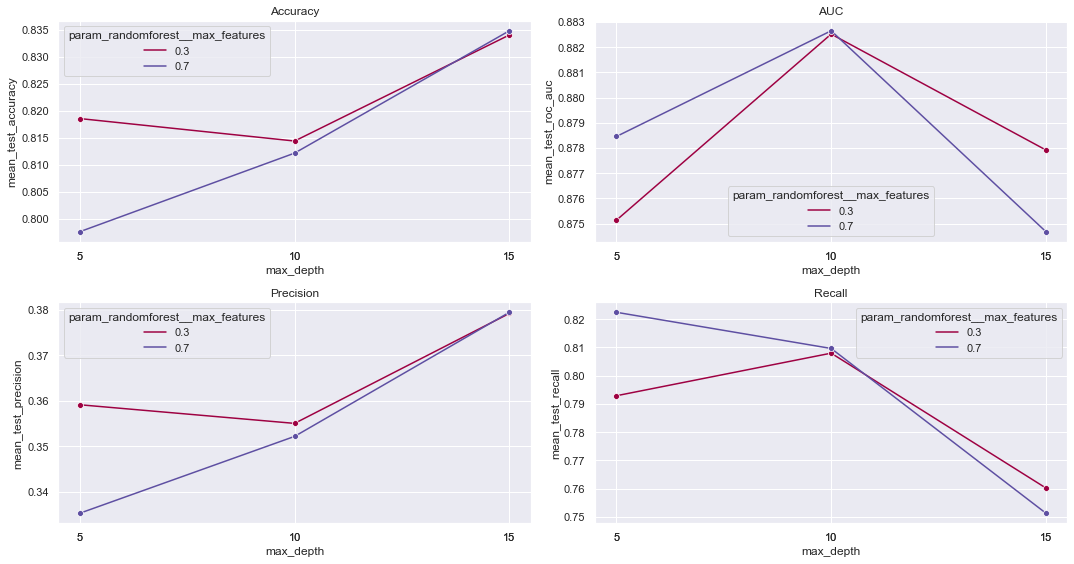

In [109]:
plot_results(results=pd.DataFrame(search_rf.cv_results_),param_hue='param_randomforest__max_features',
             param_x='param_randomforest__max_depth')

In [110]:
scores = scores.append(results_rf, ignore_index=True)
estimators = search_rf.best_estimator_.named_steps['randomforest'].estimators_
#add mean number of leaves
leaves = []
for i in estimators:
    leaves.append(i.get_n_leaves())
mean_leaves_rf = np.mean(leaves)

#add mean depth of trees
depth = []
for i in estimators:
    depth.append(i.get_depth())
mean_depth_rf = np.mean(depth)
scores.loc[scores.Model == 'Random Forest max features',
           ['leaves', 'depth']] = mean_leaves_rf, mean_depth_rf
scores


,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params,leaves,depth
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}",NaN,NaN
1,Best Decision Tree,0.898861,0.000471,0.585294,0.328650,0.875789,"{'decisiontreeclassifier__max_depth': 10, 'dec...",735.00,10.0
2,Decision Tree Simple,0.895516,0.000519,0.558079,0.330598,0.870869,NaN,16.00,4.0
3,Random Forest max features,0.812125,0.002851,0.352159,0.809622,0.882644,"{'randomforest__max_depth': 10, 'randomforest_...",663.66,10.0


Vemos que la permanencia desde última renovación y el pago directo siguen teniendo la mayor importancia.

In [111]:
FeatureImportances(search_rf.best_estimator_,'randomforest')

Permanencia_ultima                                       0.509617
Conducto_rank_10_PAGO DIRECTO                            0.294599
Permanencia                                              0.045818
Edad_asegurado_2021                                      0.022625
Actividad_rank_20_EMPLEADO                               0.018965
Conducto_rank_10_TARJETA DE CREDITO                      0.018792
Edad_asegurado_Alta                                      0.017972
Conducto_rank_10_MUNICIPAL                               0.010873
Actividad_rank_20_DOCENTE                                0.009674
Cantidad_productos                                       0.009609
Actividad_rank_20_POLICIA-SEGURIDAD-CUSTODIA             0.006437
Zona_BA interior                                         0.005779
Productor_Otros                                          0.004851
Conducto_rank_10_POLICIA                                 0.004120
Conducto_rank_10_MINISTERIO                              0.003454
Herederos_

In [112]:
print(classification_report(yval,search_rf.predict(Xval)))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     62196
           1       0.35      0.82      0.49      7830

    accuracy                           0.81     70026
   macro avg       0.66      0.81      0.69     70026
weighted avg       0.90      0.81      0.84     70026



<a id='xgb'></a>
### XGBoost

Otro modelo de ensamble en base a árboles con el que probamos es XGBoost. 

En primer lugar corremos un modelo de XGBoost para identificar el número conveniente de iteraciones, incluyendo el parámetros scale_pos_weight para ajustar por desbalanceo.

In [113]:
scale_pos_weight=ytrain.value_counts()[0]/ytrain.value_counts()[1]
scale_pos_weight

7.942628184662538

In [114]:
xgb_basic=XGBClassifier(
    random_state=1, 
    use_label_encoder=False,
    tree_method='hist',
    verbosity=1,
    eval_metric=['auc','error'],
    n_estimators= 300,      # Number of boosted trees to fit.
    max_depth= 3,            # Maximum tree depth for base learners.
    learning_rate=0.1,# Boosting learning rate (xgb’s “eta”)     
    scale_pos_weight=scale_pos_weight
                    
                       )


Separamos el transformador de features para poder aplicarlo sobre el set de validación

In [115]:
pipe_transform=make_pipeline(pipe_selection_1,k_best)

In [116]:
Xtrain_trans=pipe_transform.fit_transform(Xtrain,ytrain)
Xval_trans=pipe_transform.transform(Xval)

Agragamos como eval_set los sets de train y validación

In [117]:
pipe_xgb=Pipeline([('features',pipe_selection_1),('kbest',k_best),
                  ('xgboost',xgb_basic)])
pipe_xgb
pipe_xgb.fit(Xtrain,ytrain,xgboost__eval_set=[(Xtrain_trans, ytrain),(Xval_trans,yval)],
            xgboost__verbose=False);

In [118]:
# mean average precision results
iteration_xgb_map = pipe_xgb.named_steps['xgboost'].evals_result()[
    'validation_0']['auc']
iteration_xgb_map_1 = pipe_xgb.named_steps['xgboost'].evals_result()[
    'validation_1']['auc']

# pasar de error a accuracy
iteration_xgb_error = pipe_xgb.named_steps['xgboost'].evals_result()['validation_0']['error']
iteration_xgb_accuracy = []
for i in iteration_xgb_error:
    iteration_xgb_accuracy.append(1-i)

table_plot = pd.DataFrame(data={'n iteration': range(1, len(iteration_xgb_map)+1), 
                                'score_train': iteration_xgb_map,
                                'score_test': iteration_xgb_map_1})


Graficamos el valor de AUC en cada iteración para train y validation para entender primero en qué iteracion se estabiliza el resultado (y aumentar iteraciones no trae una mejora significativa), y para revisar que no tengamos overfitting (train mejora pero validation no). 
En este caso vemos que no hay overfitting, y que si bien sigue aumentando, las mejoras en AUC son  leves. Podriamos quedarnos solo con 150 iteraciones sin tener problemas en los resultados. 

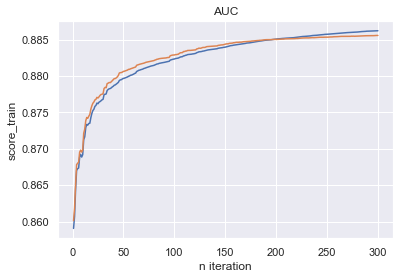

In [119]:
sns.lineplot(data=table_plot,x='n iteration',y='score_train')
sns.lineplot(data=table_plot,x='n iteration',y='score_test')
plt.title('AUC');

In [120]:
results_xgb=calculate_cv_results(pipe_xgb,Xtrain,ytrain,'XGBoost')

mean accuracy:  0.8001828066323959 std_accuracy:  0.002698785156468125
mean roc_auc:  0.8834374063727595 std roc_auc 0.0015075020690115517
mean precision:  0.3390790764976738 std precision 0.0031939862518018365
mean recall:  0.8287784413193776 std recall 0.0023469348437245847


#### XGBoost max depth & learning rate tuning

Ajustamos parámetros para máxima produndidad y learning rate. 

In [121]:
params_xgb = {  
    "xgboost__n_estimators": [150],      # Number of boosted trees to fit.
    "xgboost__max_depth": range(2,13,3),            # Maximum tree depth for base learners.
    "xgboost__learning_rate": [0.1,0.2], 
    'xgboost__tree_method':['hist']
}

search_xgb=GridSearchCV(estimator=pipe_xgb,
                        param_grid=params_xgb, 
                        cv=folds, 
                        n_jobs=-1,
                        scoring=['accuracy','precision','recall','roc_auc'], 
                        refit='roc_auc',
                        verbose=1)

search_xgb.fit(Xtrain,ytrain)
xgb_results=results_grid(search_xgb,'XGboost')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.0min finished


Accuracy: 0.8019214533597179 , Std:  0.0014115588610896807
Precision CV:  0.34092941052685977
Recall CV:  0.826543677039728
AUC CV:  0.8838770958214385
Params: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 150, 'xgboost__tree_method': 'hist'}


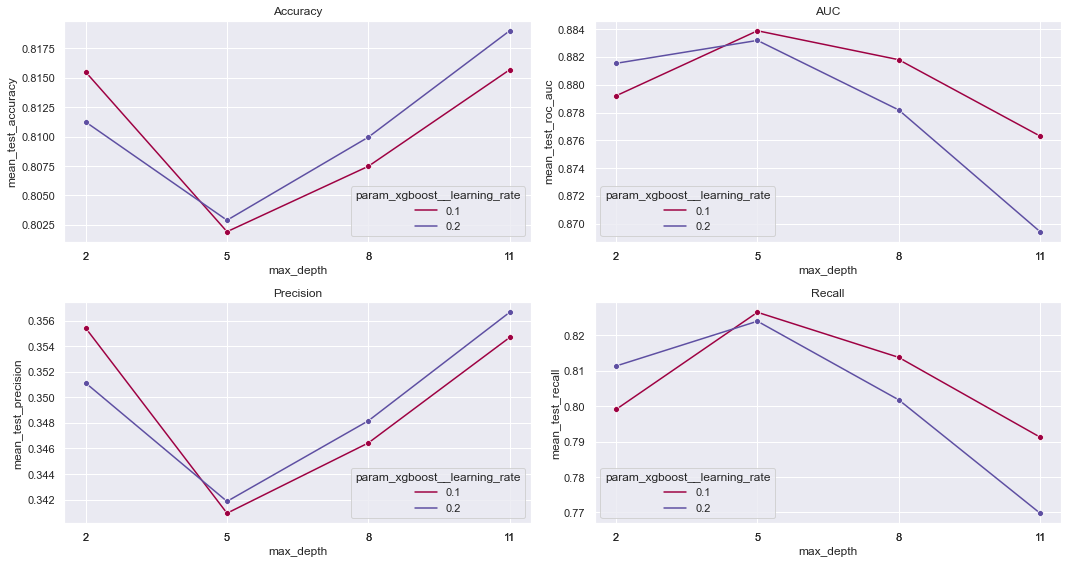

In [122]:
plot_results(results=pd.DataFrame(search_xgb.cv_results_),param_x='param_xgboost__max_depth',
             param_hue='param_xgboost__learning_rate')

In [123]:
scores=scores.append(xgb_results,ignore_index=True)
scores

,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params,leaves,depth
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}",NaN,NaN
1,Best Decision Tree,0.898861,0.000471,0.585294,0.328650,0.875789,"{'decisiontreeclassifier__max_depth': 10, 'dec...",735.00,10.0
2,Decision Tree Simple,0.895516,0.000519,0.558079,0.330598,0.870869,NaN,16.00,4.0
3,Random Forest max features,0.812125,0.002851,0.352159,0.809622,0.882644,"{'randomforest__max_depth': 10, 'randomforest_...",663.66,10.0
4,XGboost,0.801921,0.001412,0.340929,0.826544,0.883877,"{'xgboost__learning_rate': 0.1, 'xgboost__max_...",NaN,NaN


Feature importances

In [124]:
FeatureImportances(search_xgb.best_estimator_,'xgboost')

Conducto_rank_10_PAGO DIRECTO                            0.362127
Permanencia_ultima                                       0.286392
Actividad_rank_20_EMPLEADO                               0.043335
Conducto_rank_10_TARJETA DE CREDITO                      0.031288
Actividad_rank_20_DOCENTE                                0.023090
Conducto_rank_10_MINISTERIO                              0.021783
Productor_Otros                                          0.016218
Conducto_rank_10_POLICIA                                 0.015667
Conducto_rank_10_I.P.S.                                  0.015333
Actividad_rank_20_JUBILADO                               0.013356
Conducto_rank_10_JUDICIALES                              0.013002
Actividad_rank_20_POLICIA-SEGURIDAD-CUSTODIA             0.012578
Actividad_rank_20_COMERCIANTE                            0.010330
Zona_BA interior                                         0.010121
Actividad_rank_20_AMA DE CASA                            0.008416
Actividad_

<a id='logistic'></a>
### Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression

In [126]:
logreg=LogisticRegression(class_weight='balanced')

Generamos un pipeline agregando además el escalador standard scaler.

In [127]:
pipe_logreg=Pipeline([('features',pipe_selection_1),('kbest',k_best),('scaling',standard_scaler),
                  ('logistic_regression',logreg)])

Corremos un grid search para distintos valores de k en SelectKBest, y C para la regresión logística.

In [128]:
params = dict(kbest__k=[10, 'all'],
              logistic_regression__C=[0.5, 1, 2],
              features=[pipe_selection_1, pipe_selection_3]
              )

search_logreg = GridSearchCV(pipe_logreg, param_grid=params,
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], 
                             refit='roc_auc', verbose=1, n_jobs=-1,cv=folds)
search_logreg.fit(Xtrain, ytrain)
results_logreg = results_grid(search_logreg, 'Logistic Regression')


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Accuracy: 0.7957486771118963 , Std:  0.0015936648683043447
Precision CV:  0.33069177097608715
Recall CV:  0.8071322720744798
AUC CV:  0.8737464917777938
Params: {'features': Pipeline(steps=[('featureselection',
                 FeatureSelection(selected_features=['Permanencia_ultima',
                                                     'Permanencia',
                                                     'Cantidad_productos',
                                                     'Edad_asegurado_Alta',
                                                     'Edad_asegurado_2021',
                                                     'Productor',
                                                     'Herederos_Legales_(S/N)',
                                                     'Actividad_rank_20',
                                                     'Conducto_rank_10',
                                                     'Zona'])),
                ('columntransformer',
                 ColumnT

In [129]:
print(classification_report(yval,search_logreg.predict(Xval)))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     62196
           1       0.33      0.81      0.47      7830

    accuracy                           0.80     70026
   macro avg       0.65      0.80      0.67     70026
weighted avg       0.90      0.80      0.83     70026



In [130]:
scores=scores.append(results_logreg,ignore_index=True)
scores

,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params,leaves,depth
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}",NaN,NaN
1,Best Decision Tree,0.898861,0.000471,0.585294,0.328650,0.875789,"{'decisiontreeclassifier__max_depth': 10, 'dec...",735.00,10.0
2,Decision Tree Simple,0.895516,0.000519,0.558079,0.330598,0.870869,NaN,16.00,4.0
3,Random Forest max features,0.812125,0.002851,0.352159,0.809622,0.882644,"{'randomforest__max_depth': 10, 'randomforest_...",663.66,10.0
4,XGboost,0.801921,0.001412,0.340929,0.826544,0.883877,"{'xgboost__learning_rate': 0.1, 'xgboost__max_...",NaN,NaN
5,Logistic Regression,0.795749,0.001594,0.330692,0.807132,0.873746,{'features': (FeatureSelection(selected_featur...,NaN,NaN


<a id='oversampling'></a>
### OverSampling

Para el caso del decision tree en el cual no habíamos ajustado por desbalanceo, realizamos oversampling, de forma tal que ambas clases quedan con el mismo peso. 

In [131]:


undersampler = RandomUnderSampler(sampling_strategy='majority')
oversampler = RandomOverSampler(sampling_strategy='minority')
Xtrain_us, ytrain_us = undersampler.fit_resample(Xtrain, ytrain)
Xtrain_os, ytrain_os = oversampler.fit_resample(Xtrain, ytrain)


In [132]:
ytrain.value_counts(normalize=True)

0    0.888176
1    0.111824
Name: anulacion_target, dtype: float64

In [133]:
ytrain_os.value_counts(normalize=True)

0    0.5
1    0.5
Name: anulacion_target, dtype: float64

Clonamos el árbol de decisión que habíamos conseguido con grid search, para usar los mismos hiperparámetros y entrenarlo con la muestra de train con oversampling.

In [134]:
dt_best_params=clone(search_dt.best_estimator_)

No usamos para la validación los resultados de cross validation, ya que estarían usando la muestra con oversampling, y tenemos que medir la performance con una muestra lo más real posible.

In [135]:
dt_best_params.fit(Xtrain_os, ytrain_os)
calculate_cv_results(dt_best_params, Xtrain_os, ytrain_os, 'Oversampling DT')
print(classification_report(yval, dt_best_params.predict(Xval)))
ypred_val_os_dt = dt_best_params.predict(Xval)
results_os_dt = {
    'Model': 'Oversampling DT',
    'Accuracy CV': accuracy_score(yval, ypred_val_os_dt),
    'Precision CV': precision_score(yval, ypred_val_os_dt),
    'Recall CV': recall_score(yval, ypred_val_os_dt),
    'AUC CV': roc_auc_score(yval, dt_best_params.predict_proba(Xval)[:, 1])
}
results_os_dt


mean accuracy:  0.8168253773493583 std_accuracy:  0.0007375462564713618
mean roc_auc:  0.8889509325811963 std roc_auc 0.0009492025864647391
mean precision:  0.8075816955411297 std precision 0.0060473083549039686
mean recall:  0.8320356368926609 std recall 0.008956881125402428
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     62196
           1       0.34      0.83      0.48      7830

    accuracy                           0.80     70026
   macro avg       0.66      0.81      0.68     70026
weighted avg       0.90      0.80      0.83     70026



{'Model': 'Oversampling DT',
 'Accuracy CV': 0.800502670436695,
 'Precision CV': 0.339064793457748,
 'Recall CV': 0.8260536398467433,
 'AUC CV': 0.8771814427213044}

In [136]:
scores=scores.append(results_os_dt,ignore_index=True)
scores

,Model,Accuracy CV,Accuracy STD,Precision CV,Recall CV,AUC CV,Params,leaves,depth
0,Naive Bayes,0.889772,0.001357,0.510221,0.367122,0.861362,"{'kbest__k': 15, 'model': MultinomialNB()}",NaN,NaN
1,Best Decision Tree,0.898861,0.000471,0.585294,0.328650,0.875789,"{'decisiontreeclassifier__max_depth': 10, 'dec...",735.00,10.0
2,Decision Tree Simple,0.895516,0.000519,0.558079,0.330598,0.870869,NaN,16.00,4.0
3,Random Forest max features,0.812125,0.002851,0.352159,0.809622,0.882644,"{'randomforest__max_depth': 10, 'randomforest_...",663.66,10.0
4,XGboost,0.801921,0.001412,0.340929,0.826544,0.883877,"{'xgboost__learning_rate': 0.1, 'xgboost__max_...",NaN,NaN
5,Logistic Regression,0.795749,0.001594,0.330692,0.807132,0.873746,{'features': (FeatureSelection(selected_featur...,NaN,NaN
6,Oversampling DT,0.800503,NaN,0.339065,0.826054,0.877181,NaN,NaN,NaN


Con este método invertimos precision y recall para los positivos. Ganamos recall (encontramos más casos positivos) a costa de perder precisión (tenemos más falsos positivos). 

<a id='seleccion'></a>
### Comparación de resultados y selección del modelo

Comparación de curva ROC.

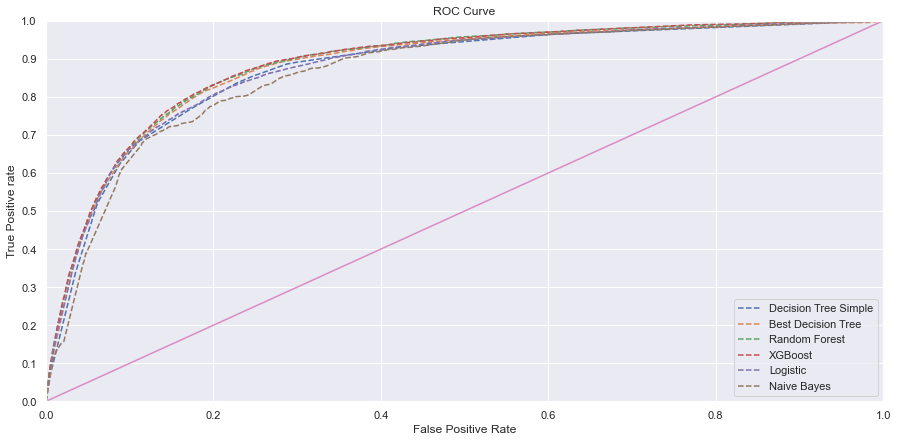

In [137]:
p1 = pipe_dt.predict_proba(Xval)
p2 = search_dt.predict_proba(Xval)
p3 = search_rf.predict_proba(Xval)
p4 = search_xgb.predict_proba(Xval)
p5 = search_logreg.predict_proba(Xval)
p6 = nb_search.predict_proba(Xval)


# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(yval, p1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(yval, p2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(yval, p3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(yval, p4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(yval, p5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(yval, p6[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(yval))]
p_fpr, p_tpr, _ = roc_curve(yval, random_probs, pos_label=1)

plt.figure(figsize=(15,7))
plt.plot(fpr1, tpr1, linestyle='--', label='Decision Tree Simple')
plt.plot(fpr2, tpr2, linestyle='--', label='Best Decision Tree')
plt.plot(fpr3, tpr3, linestyle='--', label='Random Forest')
plt.plot(fpr4, tpr4, linestyle='--', label='XGBoost')
plt.plot(fpr5, tpr5, linestyle='--', label='Logistic')
plt.plot(fpr6, tpr6, linestyle='--', label='Naive Bayes')


plt.plot(p_fpr, p_tpr, linestyle='-')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(np.linspace(0,1,11));

Comparación de resultados

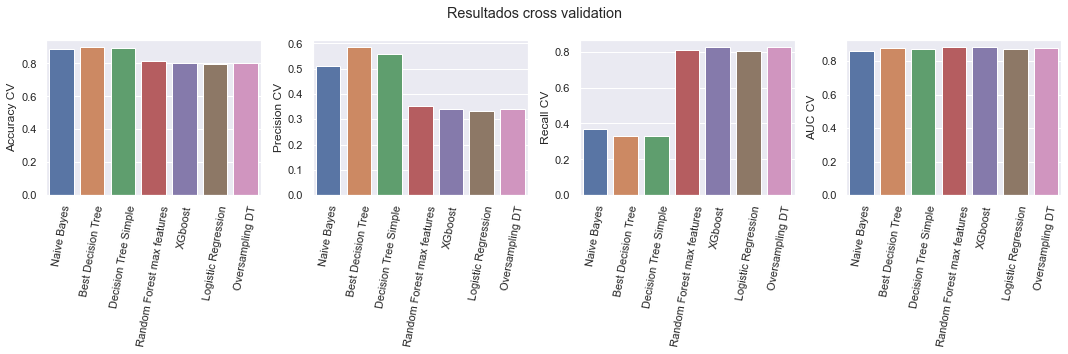

In [150]:
fig,ax=plt.subplots(1,4,figsize=(15,5))
counter=0
for i in ['Accuracy CV','Precision CV','Recall CV','AUC CV']:
    sns.barplot(data=scores,x='Model',y=i,ax=ax[counter])
    ax[counter].set_xticklabels(ax[counter].get_xticklabels(), rotation = 80)
    ax[counter].set_xlabel('')
    counter+=1
fig.suptitle('Resultados cross validation')
plt.tight_layout();

En el caso de oversampling, los resultados son del set de validacion y no de cross validation.

## Selected Model

Elegimos XGBoost que tiene los mejores resultados, aunque las diferencias con Decision Tree y Random Forest no son muy grandes. 

In [139]:
scores.set_index('Model').iloc[:,:5].loc['XGboost']

Accuracy CV     0.801921
Accuracy STD    0.001412
Precision CV    0.340929
Recall CV       0.826544
AUC CV          0.883877
Name: XGboost, dtype: float64

Graficamos la curva de precision vs recall.

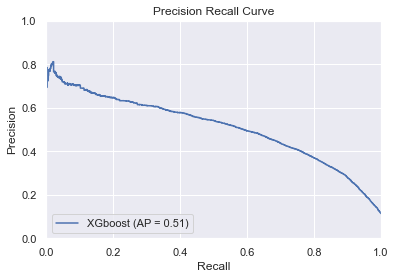

In [140]:
plot_precision_recall_curve(search_xgb,Xval,yval,name='XGboost')
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Precision Recall Curve');

Guardamos el modelo en un archivo pickle

In [141]:
with open('modelo.pkl', 'wb') as modelo_xgb:
    pickle.dump(search_xgb, modelo_xgb)


<a id='test'> </a>
## Test predictions

In [142]:
ypred=search_xgb.predict(Xtest)

Podemos ver que las predicciones con los datos de test (nunca antes vistos por el modelo) están en línea con los valores que vimos en cross validation.

In [143]:
print(classification_report(ytest,search_xgb.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     77744
           1       0.34      0.82      0.48      9788

    accuracy                           0.80     87532
   macro avg       0.66      0.81      0.68     87532
weighted avg       0.90      0.80      0.83     87532



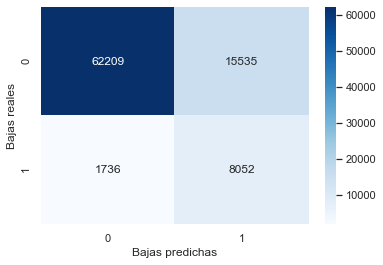

In [144]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f',cmap='Blues');
plt.ylabel('Bajas reales')
plt.xlabel('Bajas predichas');

### Analisis predicciones

Predecimos sobre todo el dataset para comparar cómo quedan las distribuciones de las predicciones. Está claro que para los primeros años el modelo da muchos falsos positivos, lo cual habiamos visto previamente con un precision tan bajo de 34%.

In [145]:
ypred = search_xgb.predict(X)
data_pred = X.copy()
data_pred['ypred'] = ypred
data_pred['yreal'] = y

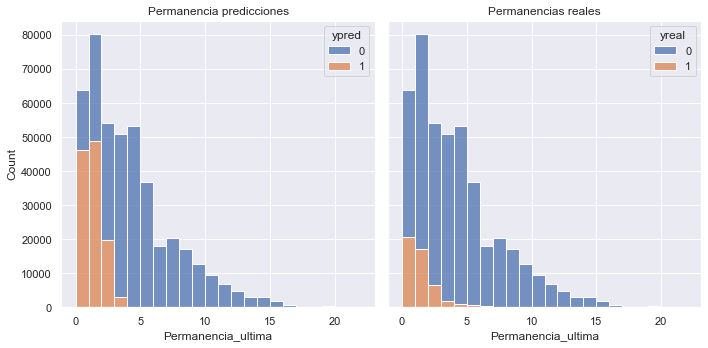

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),sharey=True)
sns.histplot(data=data_pred, x='Permanencia_ultima', hue='ypred', binwidth=1, ax=ax1, multiple='stack')
sns.histplot(data=data_pred, x='Permanencia_ultima', hue='yreal', binwidth=1, ax=ax2, multiple='stack')
ax1.set_title('Permanencia predicciones')
ax2.set_title('Permanencias reales')
plt.tight_layout()


<a id='conclusiones'></a>
## Conclusiones

Nuestros 2 objetivos eran predecir las bajas potenciales dentro de la cartera actual, y brindar explicaciones acerca de los factores que influyen. 

En cuanto a las predicciones, nuestro modelo tiene una precisión de 34% y una sensitividad (recall) de 84%. Esto significa que de todas las bajas que existen realmente, nuestro modelo encuentra el 84%, pero solo el 34% de lo que predice el modelo realmente es baja (hay muchos falsos positivos). 

Usamos el valor default de 0.5 para indicar a partir de qué probabilidad de baja el cliente es clasificado como tal. Por ejemplo, si para un cliente el modelo determina una probabilidad de 0.6 de ser baja, entonces es clasificado como baja, pero si es 0.4 no. En el caso que en el futuro la empresa tenga alguna preferencia por aumentar la presición y reducir los falsos positivos, tenemos la posibilidad de cambiar este límite. Por ejemplo, si sólo marcaramos los clientes con probabilidad de 0.8 de ser baja como baja, entonces aumentaríamos la precisión (ya que estamos más seguros de nuestras predicciones positivas), pero perderíamos sensitividad, es decir encontraríamos menos casos. El tradeoff entre estos indicadores puede verse en la curva precision recall. 


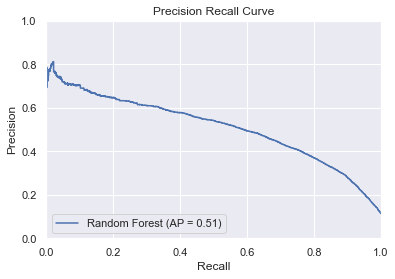

In [147]:
fig, ax = plt.subplots(1, 1)
plot_precision_recall_curve(search_xgb, Xval, yval, name='Random Forest', ax=ax)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title('Precision Recall Curve');


Por el lado de la importancia de las features, todos nuestros modelos encontraron que las variables más importantes para predecir la baja son la permanencia desde la última renovación y el pago directo. 

Habiendo graficado el árbol de decisión de 4 niveles podemos identificar que el riesgo de baja está principalmente en clientes de menos de 2 años con pago directo. 
Además factores como la edad menor a 30 años aumentan la probabilidad de baja.

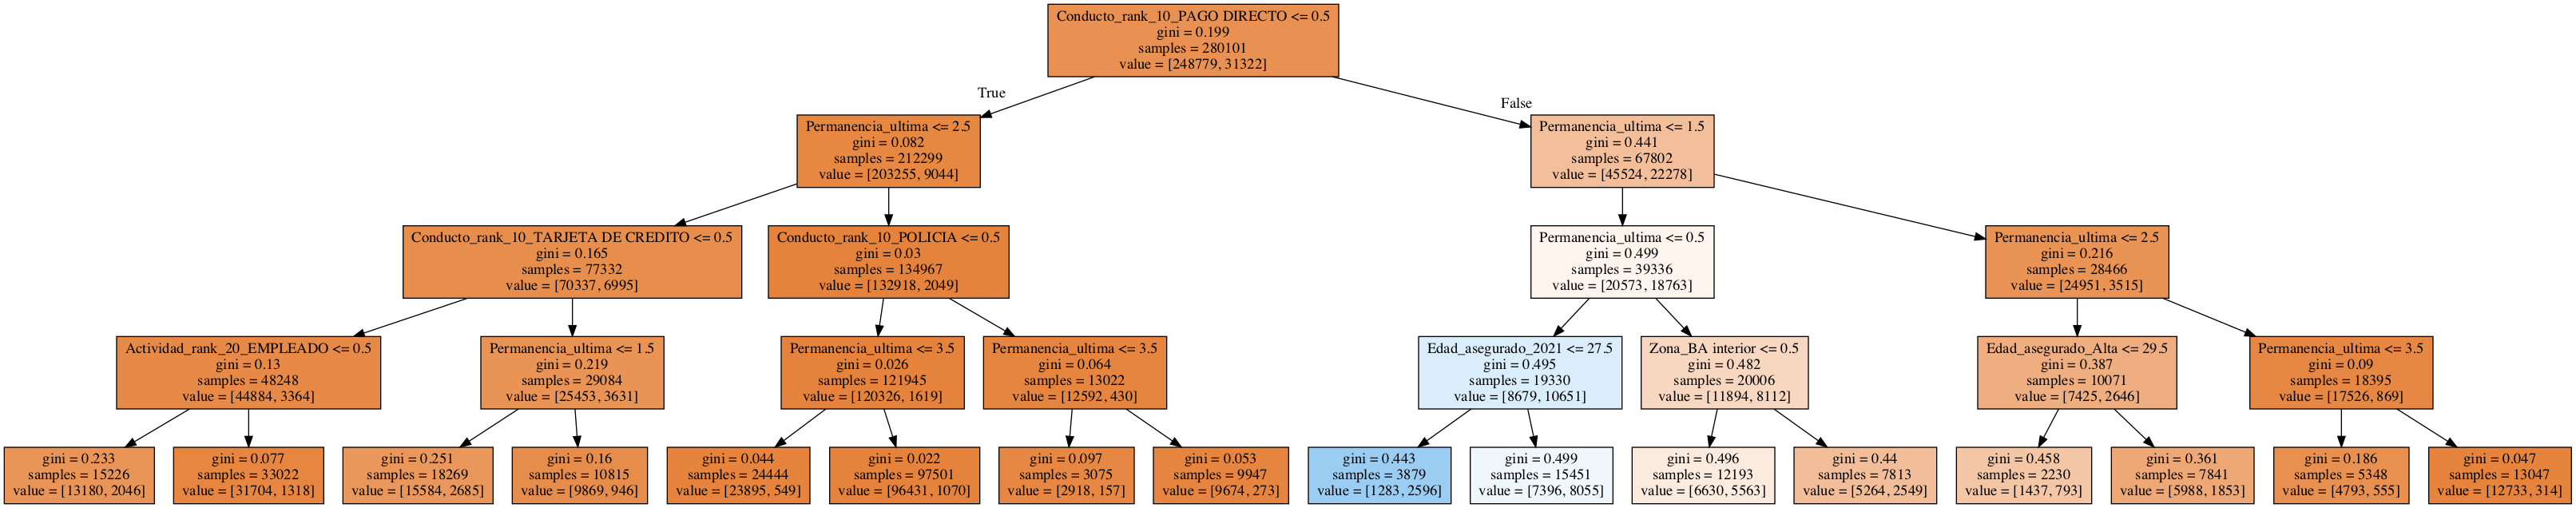

In [148]:
treeplot

En cuanto a los conductos de pago, vimos que el pago directo en los primeros años es el factor más relevante para la baja. 

El pago directo se encuentra concentrado principalmente en altas y renovaciones de los últimos 2 años, que a su vez tienen un % muy alto de anulación. 

Por otro lado pareciera que las tarjetas de crédito tienen cada vez menos peso en los últimos años, mientras que el resto de los medios de pago (en general a traves de organismos) se mantiene relativamente constante. 

Un próximo paso puede ser entender con la compañia cual es su estrategia en cuanto a métodos de pago, y por qué cada vez se apoyan más en el pago directo que tiene un alto % de anulaciones. 

Además, entender quienes son los clientes que se están sumando al pago directo. Las altas crecieron mucho en los últimos años, se hizo alguna campaña especial? Cual fue el target? Entendiendo esto podríamos identificar si el método de pago es un determinante, o hay un segmento específico de clientes que están con pago directo que por otros motivos cancela (ej campaña direccionada a clientes que no necesitan el servicio).

En esta instancia solo tenemos edad, actividad y método de pago para identificar al cliente, y sabemos que actividad no tiene datos verídicos. Obteniendo más información de distintos segmentos de clientes se puede seguir profundizando el análisis.

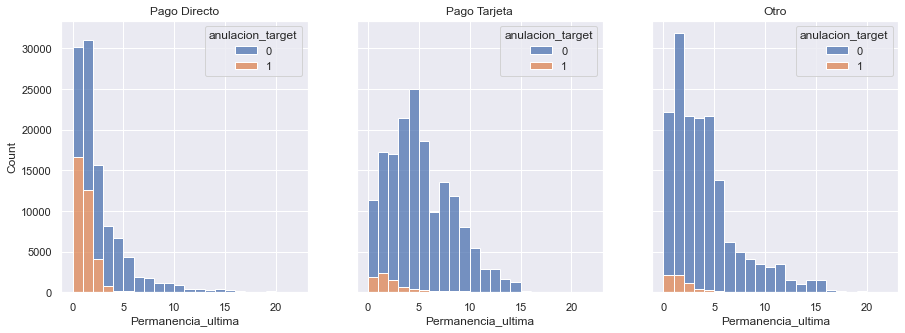

In [149]:
mask_tarjeta = data['Conducto_rank_10'] == 'TARJETA DE CREDITO'
mask_directo = data['Conducto_rank_10'] == 'PAGO DIRECTO'
mask_otros = ~(mask_directo | mask_tarjeta)

fig, ax = plt.subplots(1, 3, figsize=(15, 5),sharey=True)

sns.histplot(data=data[mask_directo],x='Permanencia_ultima',hue='anulacion_target',
             binwidth=1,multiple='stack',ax=ax[0])
ax[0].set_title('Pago Directo')

sns.histplot(data=data[mask_tarjeta],x='Permanencia_ultima',hue='anulacion_target',
             binwidth=1,multiple='stack',ax=ax[1])
ax[1].set_title('Pago Tarjeta')

sns.histplot(data=data[mask_otros],x='Permanencia_ultima',hue='anulacion_target',
             binwidth=1,multiple='stack',ax=ax[2])
ax[2].set_title('Otro');